# Settings, Directory Specs, and Imports

In [15]:
# 0 = no streamlit
# 1 = test user inputs
# 2 = run in streamlit
streamlit_status = 1 

dir_read = '/Users/rachellehorwitz/Documents/VTAlert/data/filtered02/'
#dir_read = '/Users/rachellehorwitz/Documents/VTAlert/over18_eicu/'

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import streamlit as st

In [16]:
def train_model(X_train, y_train):
    logisticRegr_sc = make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced'))
    logisticRegr_sc.fit(X_train, y_train)
    return logisticRegr_sc

In [17]:
st.title('ViTalErt: Risk Monitoring for Venous Thromboembolism in ICU Patients')

# eICU Data Wrangling

In [18]:
# Read files from csv
patient = pd.read_csv(dir_read + 'patient.csv')
admissiondx = pd.read_csv(dir_read + 'admissiondx.csv')
diagnosis = pd.read_csv(dir_read + 'diagnosis.csv')
ptusid_pos = pd.read_csv(dir_read + 'pos_ptunitstayid.csv')

# Create dataframe of patientunitstayids in negative class
tmp = patient[~patient['patientunitstayid'].isin(ptusid_pos['patientunitstayid'])]
ptusid_neg = tmp[['patientunitstayid']]

# Create labels
ptusid_neg.loc[:,'label'] = 0
ptusid_pos.loc[:,'label'] = 1

# Add labels to "patient" dataframe and move 'label' column to left
ptusid_w_label = pd.concat([ptusid_pos, ptusid_neg])
ptusid_w_label.shape[0]
ptusid_w_label = ptusid_w_label.set_index('patientunitstayid')
patient = patient.set_index('patientunitstayid')
patient = patient.join(ptusid_w_label)

# Move 'label' column to left
cols = list(patient.columns)
cols = [cols[-1]] + cols[:-1]
patient = patient[cols]

/Users/rachellehorwitz/opt/anaconda3/envs/insight/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/rachellehorwitz/opt/anaconda3/envs/insight/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [19]:
patient.head(5)

,label,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,...,unitadmitsource,unitvisitnumber,unitstaytype,admissionweight,dischargeweight,unitdischargetime24,unitdischargeoffset,unitdischargelocation,unitdischargestatus,uniquepid
patientunitstayid,,,,,,,,,,,,,,,,,,,,,
141168,0,128919,Female,70,Caucasian,59,91,"Rhythm disturbance (atrial, supraventricular)",152.4,15:54:00,...,Direct Admit,1,admit,84.3,85.8,03:50:00,3596,Death,Expired,002-34851
141194,0,128941,Male,68,Caucasian,73,92,"Sepsis, renal/UTI (including bladder)",180.3,18:18:40,...,Floor,1,admit,73.9,76.7,15:31:00,4813,Floor,Alive,002-5276
141197,0,128943,Male,71,Caucasian,67,109,"Sepsis, pulmonary",162.6,20:21:00,...,Emergency Department,1,admit,102.1,102.1,22:00:00,74,Step-Down Unit (SDU),Alive,002-37665
141203,0,128948,Female,77,Caucasian,66,90,"Arrest, respiratory (without cardiac arrest)",160.0,22:23:00,...,Floor,1,admit,70.2,70.3,03:48:00,1869,Floor,Alive,002-23234
141208,0,128952,Female,25,Caucasian,73,93,"Overdose, sedatives, hypnotics, antipsychotics...",172.7,11:23:00,...,Emergency Department,1,admit,95.3,95.3,23:24:00,720,Home,Alive,002-34521


# Defining X and y

In [20]:
# Define X and y
X = patient[['age', 'admissionweight']]
y = patient['label']

# Partition and train model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [21]:
# X_test.iloc[0]

In [22]:
X_train['admissionweight'].nlargest(30)

patientunitstayid
1519434    953.0
533296     909.9
1595504    855.0
426451     850.0
898740     838.0
1109465    818.0
235166     779.8
1135942    771.2
1131264    735.0
1693854    713.0
225129     641.7
2262296    639.6
2979892    630.9
1572651    606.0
196327     544.0
2865118    477.0
473823     362.8
2967305    350.6
2705541    334.2
1822927    323.9
2010133    313.4
1992200    313.0
2357348    304.8
2167010    303.0
1008197    302.8
3210862    299.3
236346     297.7
654048     295.4
2840943    294.8
2127651    294.8
Name: admissionweight, dtype: float64

<IPython.core.display.Javascript object>


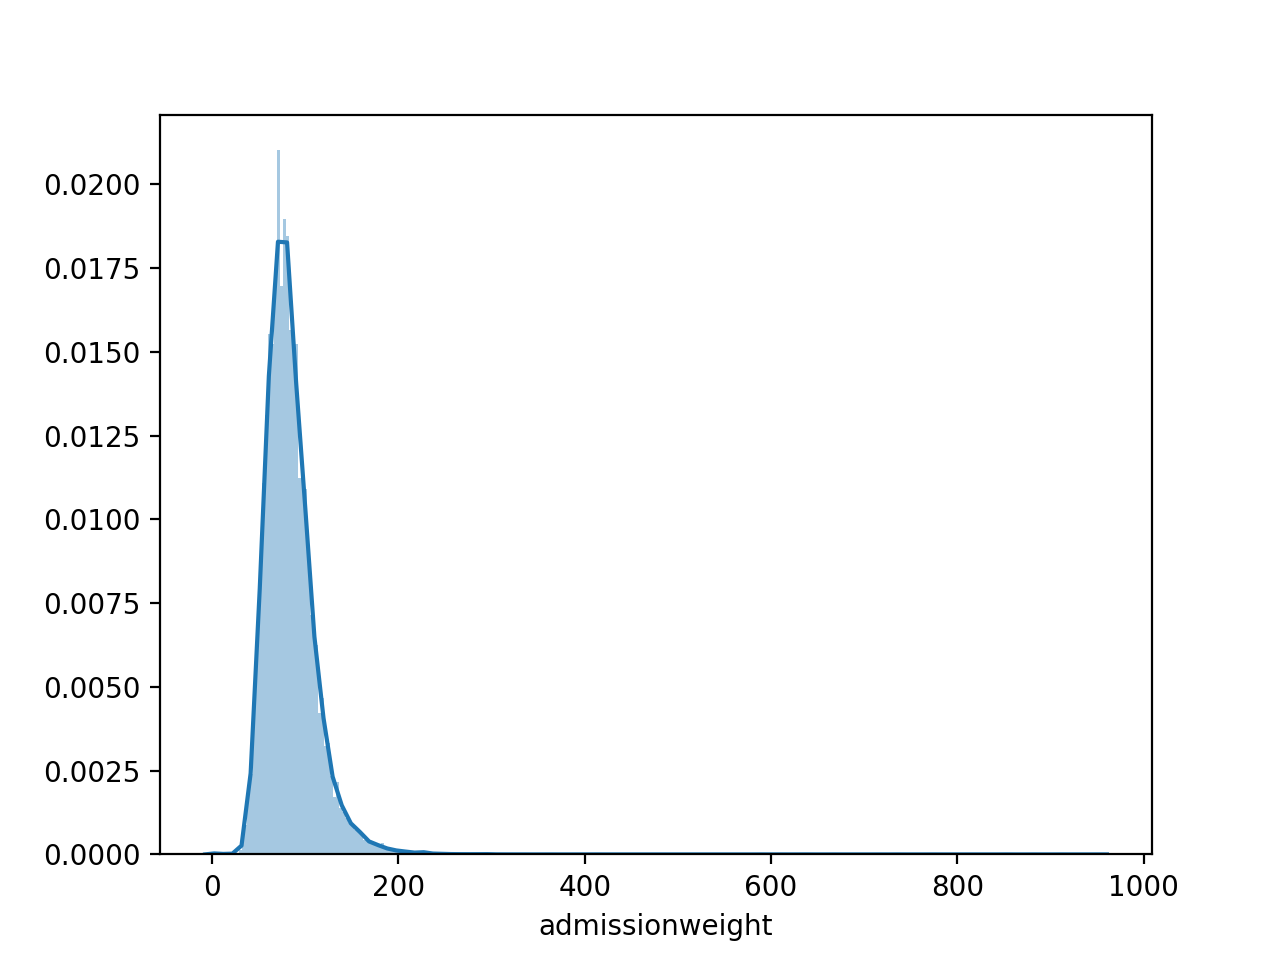

In [23]:
%matplotlib notebook
import seaborn as sns
sns.distplot(patient['admissionweight'], bins=300)

In [24]:
if streamlit_status == 1:
    age = 30
    admissionweight = 50

if streamlit_status == 2:
    age = st.slider('Age', 19, 90)
    admissionweight = ('Admission Weight (kg)', 20, 300)

if (streamlit_status == 1) | (streamlit_status == 2): 
    input_data = {'age': [age], 'admissionweight': [admissionweight]}
    X_test = pd.DataFrame(input_data, columns=['age', 'admissionweight'])

# Model and Predict

In [25]:
logisticRegr_sc = train_model(X_train, y_train)

predictions_sc = logisticRegr_sc.predict(X_test)
prob_sc = logisticRegr_sc.predict_proba(X_test)[:,1]
#lprob_sc = logisticRegr_sc.predict_log_proba(X_test)[:,1]
if streamlit_status == 0:
    scores_sc = logisticRegr_sc.score(X_test, y_test)
    print(scores_sc)

In [26]:
print('prob_sc:  min = ' + str(np.min(prob_sc)))
print('\t    max = ' + str(np.max(prob_sc)))

prob_sc:  min = 0.4058219828284395
	    max = 0.4058219828284395


In [33]:
st.write(' The risk of VTE is: ' + str(prob_sc[0]) + '%')

In [28]:
# Baseline if always predict 0: wrong only for when y is 1
N0_bl = patient[patient['label']==0].shape[0]
N1_bl = patient[patient['label']==1].shape[0]

print(str(N0_bl))
print(str(N1_bl))
print(N0_bl/(N0_bl + N1_bl))

162165
1987
0.987895365271212
